# Rank-Preserving Calibration Examples

This notebook demonstrates how to use the `rank_preserving_calibration` package for various real-world scenarios.

## Installation

Make sure you have the package installed:
```bash
pip install -e .
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from examples.data_helpers import (
    analyze_calibration_result,
    create_realistic_classifier_case,
    create_survey_reweighting_case,
    create_test_case,
)

# Import our calibration package
from rank_preserving_calibration import (
    calibrate_admm,
    calibrate_dykstra,
)

# Set style for nice plots
plt.style.use("default")
# Use matplotlib's built-in color cycle
plt.rcParams["axes.prop_cycle"] = plt.cycler(
    "color", ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
)
np.random.seed(42)

## Example 1: Basic Usage

Let's start with a simple example to understand the basic workflow.

In [2]:
# Generate random test data
P, M = create_test_case("random", N=50, J=4, seed=42)

print(f"Generated probability matrix P: shape {P.shape}")
print(f"Original column sums: {P.sum(axis=0)}")
print(f"Target marginals M: {M}")
print(f"Marginal differences: {P.sum(axis=0) - M}")

Generated probability matrix P: shape (50, 4)
Original column sums: [11.53788492 11.79637058 14.13392993 12.53181457]
Target marginals M: [12.5 12.5 12.5 12.5]
Marginal differences: [-0.96211508 -0.70362942  1.63392993  0.03181457]


In [3]:
# Calibrate using Dykstra's method
result = calibrate_dykstra(P, M, verbose=True)

print("\nCalibration Results:")
print(f"Converged: {result.converged}")
print(f"Iterations: {result.iterations}")
print(f"Final column sums: {result.Q.sum(axis=0)}")
print(f"Max row error: {result.max_row_error:.2e}")
print(f"Max column error: {result.max_col_error:.2e}")
print(f"Max rank violation: {result.max_rank_violation:.2e}")

Dykstra iteration 1: change = 8.07e-02
Dykstra iteration 2: change = 2.58e-02
Dykstra iteration 3: change = 4.84e-03
Dykstra iteration 4: change = 2.20e-03
Dykstra iteration 5: change = 1.16e-03
Dykstra iteration 6: change = 6.86e-04
Dykstra iteration 7: change = 4.38e-04
Dykstra iteration 8: change = 2.94e-04
Dykstra iteration 9: change = 2.05e-04
Dykstra iteration 10: change = 1.47e-04
Dykstra converged at iteration 37

Calibration Results:
Converged: True
Iterations: 37
Final column sums: [12.5 12.5 12.5 12.5]
Max row error: 1.02e-06
Max column error: 7.11e-15
Max rank violation: 0.00e+00


## Example 2: Visualizing Calibration Impact

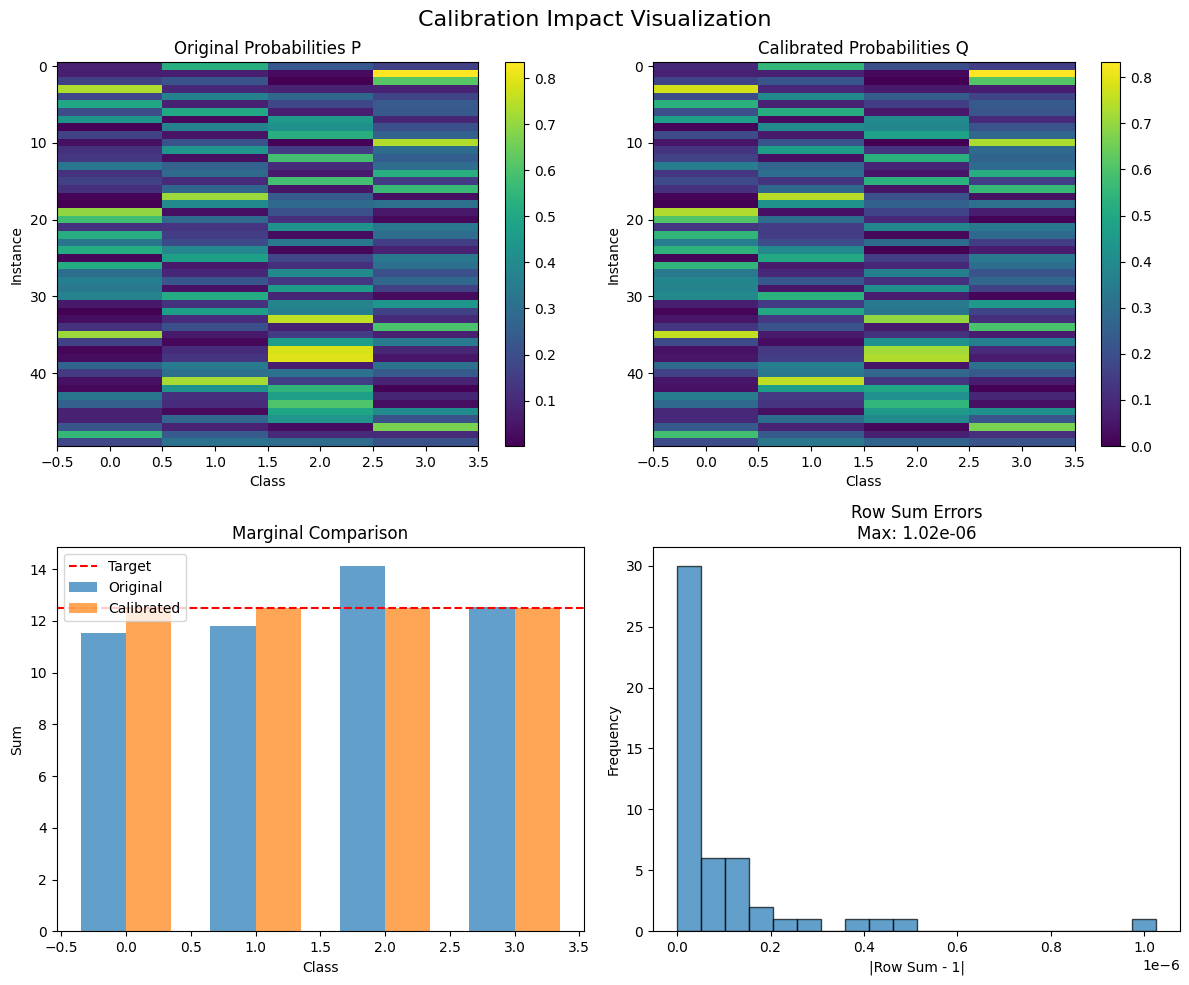

In [4]:
# Create visualization of calibration impact
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Calibration Impact Visualization", fontsize=16)

# Plot 1: Original vs Calibrated Probabilities
im1 = axes[0, 0].imshow(P, aspect="auto", cmap="viridis")
axes[0, 0].set_title("Original Probabilities P")
axes[0, 0].set_xlabel("Class")
axes[0, 0].set_ylabel("Instance")
plt.colorbar(im1, ax=axes[0, 0])

im2 = axes[0, 1].imshow(result.Q, aspect="auto", cmap="viridis")
axes[0, 1].set_title("Calibrated Probabilities Q")
axes[0, 1].set_xlabel("Class")
axes[0, 1].set_ylabel("Instance")
plt.colorbar(im2, ax=axes[0, 1])

# Plot 2: Marginal Comparison
x_pos = np.arange(len(M))
width = 0.35
axes[1, 0].bar(x_pos - width / 2, P.sum(axis=0), width, label="Original", alpha=0.7)
axes[1, 0].bar(
    x_pos + width / 2, result.Q.sum(axis=0), width, label="Calibrated", alpha=0.7
)
axes[1, 0].axhline(y=M[0], color="red", linestyle="--", label="Target")
axes[1, 0].set_title("Marginal Comparison")
axes[1, 0].set_xlabel("Class")
axes[1, 0].set_ylabel("Sum")
axes[1, 0].legend()

# Plot 3: Row sum errors
row_errors = np.abs(result.Q.sum(axis=1) - 1.0)
axes[1, 1].hist(row_errors, bins=20, alpha=0.7, edgecolor="black")
axes[1, 1].set_title(f"Row Sum Errors\nMax: {np.max(row_errors):.2e}")
axes[1, 1].set_xlabel("|Row Sum - 1|")
axes[1, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

## Example 3: Algorithm Comparison (Dykstra vs ADMM)

In [5]:
import time

# Generate a larger test case
P_large, M_large = create_test_case("skewed", N=200, J=5, seed=123, skew_factor=2.0)

print(f"Test case: {P_large.shape[0]} instances, {P_large.shape[1]} classes")
print(f"Original marginals: {P_large.sum(axis=0)}")
print(f"Target marginals: {M_large}")

# Test Dykstra's method
start_time = time.time()
result_dykstra = calibrate_dykstra(P_large, M_large, verbose=False)
time_dykstra = time.time() - start_time

# Test ADMM
start_time = time.time()
result_admm = calibrate_admm(P_large, M_large, rho=1.0, verbose=False)
time_admm = time.time() - start_time

print("\nAlgorithm Comparison:")
print(
    f"Dykstra: {time_dykstra:.3f}s, converged: {result_dykstra.converged}, iterations: {result_dykstra.iterations}"
)
print(
    f"ADMM: {time_admm:.3f}s, converged: {result_admm.converged}, iterations: {result_admm.iterations}"
)

print("\nFinal Errors:")
print(
    f"Dykstra - Row: {result_dykstra.max_row_error:.2e}, Col: {result_dykstra.max_col_error:.2e}, Rank: {result_dykstra.max_rank_violation:.2e}"
)
print(
    f"ADMM - Row: {result_admm.max_row_error:.2e}, Col: {result_admm.max_col_error:.2e}, Rank: {result_admm.max_rank_violation:.2e}"
)

Test case: 200 instances, 5 classes
Original marginals: [55.35561371 30.90616785 26.79303703 30.38658326 56.55859814]
Target marginals: [40. 40. 40. 40. 40.]

Algorithm Comparison:
Dykstra: 13.029s, converged: True, iterations: 1137
ADMM: 7.113s, converged: False, iterations: 1000

Final Errors:
Dykstra - Row: 6.10e-06, Col: 2.84e-14, Rank: 0.00e+00
ADMM - Row: 1.00e+00, Col: 4.00e+01, Rank: 0.00e+00


## Example 4: Real-World Scenario - Classifier Calibration

Let's simulate an overconfident image classifier that needs calibration.

In [6]:
# Create realistic classifier scenario
P_classifier, M_classifier, info = create_realistic_classifier_case(
    N=500, J=5, miscalibration_type="overconfident", seed=42
)

print(f"Classifier Scenario: {info['scenario']}")
print(f"Miscalibration type: {info['miscalibration_type']}")
print(f"Observed accuracy: {info['observed_accuracy']:.3f}")
print(f"Mean confidence: {info['mean_confidence']:.3f}")
print(f"True class distribution: {info['true_class_distribution']}")

# Calibrate the classifier
result_classifier = calibrate_dykstra(P_classifier, M_classifier, verbose=False)

# Analyze the impact
analysis = analyze_calibration_result(P_classifier, result_classifier, M_classifier)

print("\nCalibration Impact:")
print(f"Prediction changes: {analysis['prediction_impact']['prediction_changes']:.1%}")
print(
    f"Confidence change: {analysis['prediction_impact']['original_confidence']:.3f} → {analysis['prediction_impact']['calibrated_confidence']:.3f}"
)
print(
    f"Entropy change: {analysis['distribution_impact']['original_entropy']:.3f} → {analysis['distribution_impact']['calibrated_entropy']:.3f}"
)

Classifier Scenario: classifier_calibration
Miscalibration type: overconfident
Observed accuracy: 0.996
Mean confidence: 0.803
True class distribution: [0.36060726 0.25242508 0.17669756 0.12368829 0.0865818 ]

Calibration Impact:
Prediction changes: 0.4%
Confidence change: 0.803 → 0.764
Entropy change: 0.627 → 0.776


/Users/soodoku/Documents/GitHub/rank_preserving_calibration/rank_preserving_calibration/calibration.py:387: UserWarning: Dykstra failed to converge after 3000 iterations
  warnings.warn(f"Dykstra failed to converge after {max_iters} iterations", UserWarning)


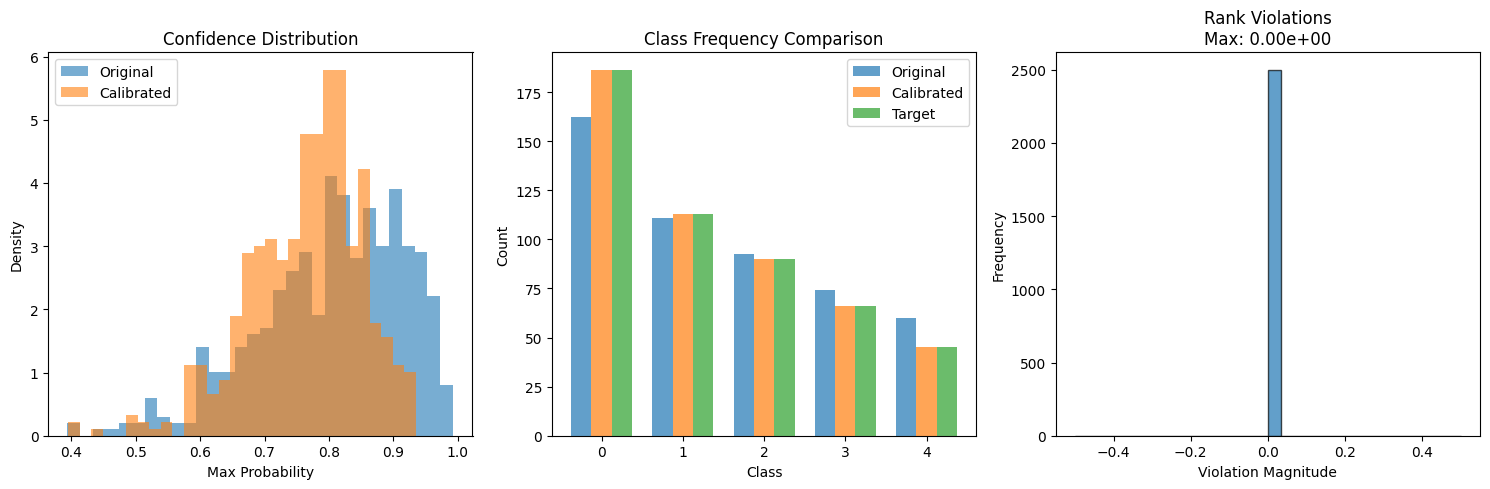

In [7]:
# Visualize classifier calibration
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Confidence distribution before/after
original_confidence = np.max(P_classifier, axis=1)
calibrated_confidence = np.max(result_classifier.Q, axis=1)

axes[0].hist(original_confidence, bins=30, alpha=0.6, label="Original", density=True)
axes[0].hist(
    calibrated_confidence, bins=30, alpha=0.6, label="Calibrated", density=True
)
axes[0].set_title("Confidence Distribution")
axes[0].set_xlabel("Max Probability")
axes[0].set_ylabel("Density")
axes[0].legend()

# Plot 2: Class frequency comparison
x_pos = np.arange(len(M_classifier))
width = 0.25
axes[1].bar(x_pos - width, P_classifier.sum(axis=0), width, label="Original", alpha=0.7)
axes[1].bar(
    x_pos, result_classifier.Q.sum(axis=0), width, label="Calibrated", alpha=0.7
)
axes[1].bar(x_pos + width, M_classifier, width, label="Target", alpha=0.7)
axes[1].set_title("Class Frequency Comparison")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")
axes[1].legend()

# Plot 3: Rank preservation check
rank_violations = []
for j in range(P_classifier.shape[1]):
    idx = np.argsort(P_classifier[:, j])
    q_sorted = result_classifier.Q[idx, j]
    violations = np.maximum(0, -np.diff(q_sorted))
    rank_violations.extend(violations)

axes[2].hist(rank_violations, bins=30, alpha=0.7, edgecolor="black")
axes[2].set_title(f"Rank Violations\nMax: {np.max(rank_violations):.2e}")
axes[2].set_xlabel("Violation Magnitude")
axes[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

## Example 5: Survey Reweighting

Simulate a political poll that needs demographic reweighting.

In [8]:
# Create survey reweighting scenario
P_survey, M_survey, info_survey = create_survey_reweighting_case(N=1000, seed=456)

print(f"Survey Scenario: {info_survey['scenario']}")
print(f"True demographics: {info_survey['true_demographics']}")
print(f"Sample demographics: {info_survey['sample_demographics']}")
print(f"Sample bias: {info_survey['sample_bias']}")
print(f"\nRaw poll results: {info_survey['raw_results']}")
print(f"Target results: {info_survey['target_results']}")

# Calibrate the survey
result_survey = calibrate_dykstra(P_survey, M_survey, verbose=False)

print("\nCalibration Results:")
print(f"Converged: {result_survey.converged} in {result_survey.iterations} iterations")
print(f"Reweighted results: {result_survey.Q.mean(axis=0)}")

# Show the impact of reweighting
categories = ["Candidate A", "Candidate B", "Candidate C", "Undecided"]
original_results = P_survey.mean(axis=0)
reweighted_results = result_survey.Q.mean(axis=0)

print("\nPoll Result Changes:")
for i, cat in enumerate(categories):
    shift = reweighted_results[i] - original_results[i]
    print(
        f"{cat}: {original_results[i]:.3f} → {reweighted_results[i]:.3f} ({shift:+.3f})"
    )

Survey Scenario: survey_reweighting
True demographics: [0.35 0.45 0.18 0.02]
Sample demographics: [0.55 0.3  0.12 0.03]
Sample bias: [ 0.2  -0.15 -0.06  0.01]

Raw poll results: [0.36134109 0.39355629 0.16962803 0.07547459]
Target results: [0.3555 0.4315 0.161  0.052 ]

Calibration Results:
Converged: True in 941 iterations
Reweighted results: [0.3555 0.4315 0.161  0.052 ]

Poll Result Changes:
Candidate A: 0.361 → 0.355 (-0.006)
Candidate B: 0.394 → 0.431 (+0.038)
Candidate C: 0.170 → 0.161 (-0.009)
Undecided: 0.075 → 0.052 (-0.023)


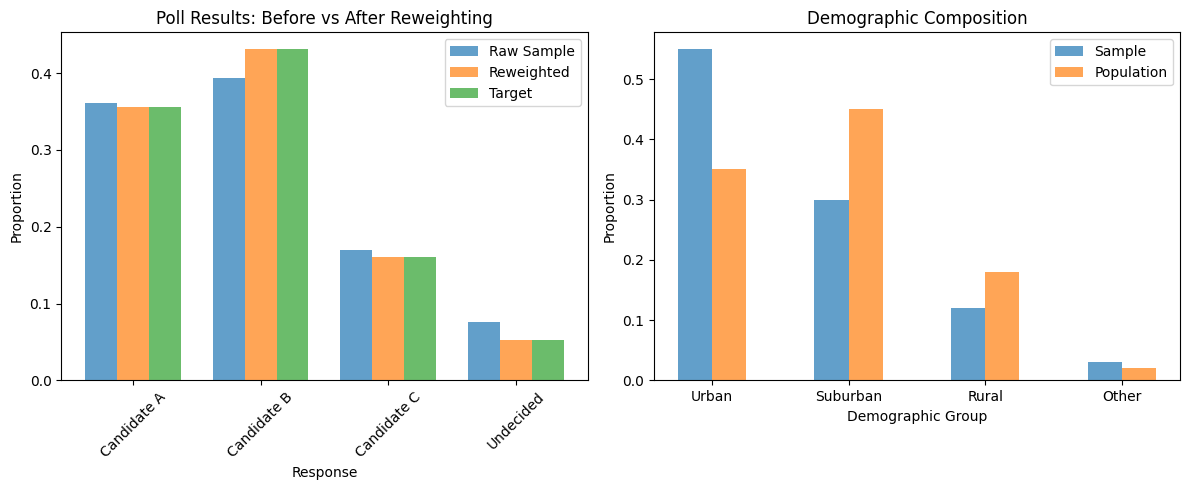

In [9]:
# Visualize survey reweighting impact
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Poll results comparison
x_pos = np.arange(len(categories))
width = 0.25

ax1.bar(x_pos - width, original_results, width, label="Raw Sample", alpha=0.7)
ax1.bar(x_pos, reweighted_results, width, label="Reweighted", alpha=0.7)
ax1.bar(x_pos + width, info_survey["target_results"], width, label="Target", alpha=0.7)

ax1.set_title("Poll Results: Before vs After Reweighting")
ax1.set_xlabel("Response")
ax1.set_ylabel("Proportion")
ax1.set_xticks(x_pos)
ax1.set_xticklabels(categories, rotation=45)
ax1.legend()

# Plot 2: Demographic bias correction
demo_labels = ["Urban", "Suburban", "Rural", "Other"]
x_pos2 = np.arange(len(demo_labels))

ax2.bar(
    x_pos2 - width / 2,
    info_survey["sample_demographics"],
    width,
    label="Sample",
    alpha=0.7,
)
ax2.bar(
    x_pos2 + width / 2,
    info_survey["true_demographics"],
    width,
    label="Population",
    alpha=0.7,
)

ax2.set_title("Demographic Composition")
ax2.set_xlabel("Demographic Group")
ax2.set_ylabel("Proportion")
ax2.set_xticks(x_pos2)
ax2.set_xticklabels(demo_labels)
ax2.legend()

plt.tight_layout()
plt.show()

## Example 6: Testing Different Scenarios

Let's test various scenarios to understand when calibration is most effective.

In [10]:
# Test different scenarios
scenarios = [
    ("Random", "random", {}),
    ("Skewed", "skewed", {"skew_factor": 3.0}),
    ("Linear Trends", "linear", {"noise_level": 0.1}),
    ("Challenging", "challenging", {"infeasibility_level": 0.2}),
]

results_summary = []

for name, case_type, kwargs in scenarios:
    # Generate test case
    P_test, M_test = create_test_case(case_type, N=100, J=4, seed=42, **kwargs)

    # Calibrate
    start_time = time.time()
    result_test = calibrate_dykstra(P_test, M_test, verbose=False, max_iters=1000)
    elapsed_time = time.time() - start_time

    # Analyze
    analysis = analyze_calibration_result(P_test, result_test, M_test)

    results_summary.append(
        {
            "scenario": name,
            "converged": result_test.converged,
            "iterations": result_test.iterations,
            "time": elapsed_time,
            "row_error": result_test.max_row_error,
            "col_error": result_test.max_col_error,
            "rank_violation": result_test.max_rank_violation,
            "prediction_changes": analysis["prediction_impact"]["prediction_changes"],
            "marginal_correction": analysis["marginal_correction"],
        }
    )

# Display results table
print("Scenario Comparison:")
print(
    f"{'Scenario':<15} {'Conv':<5} {'Iters':<6} {'Time':<8} {'Row Err':<10} {'Col Err':<10} {'Rank Viol':<12}"
)
print("-" * 80)
for r in results_summary:
    print(
        f"{r['scenario']:<15} {r['converged']!s:<5} {r['iterations']:<6} {r['time']:<8.3f} "
        f"{r['row_error']:<10.2e} {r['col_error']:<10.2e} {r['rank_violation']:<12.2e}"
    )

/Users/soodoku/Documents/GitHub/rank_preserving_calibration/rank_preserving_calibration/calibration.py:387: UserWarning: Dykstra failed to converge after 1000 iterations
  warnings.warn(f"Dykstra failed to converge after {max_iters} iterations", UserWarning)


Scenario Comparison:
Scenario        Conv  Iters  Time     Row Err    Col Err    Rank Viol   
--------------------------------------------------------------------------------
Random          True  43     0.167    1.61e-06   1.07e-14   0.00e+00    
Skewed          False 1000   4.999    1.00e-05   1.07e-14   0.00e+00    
Linear Trends   True  141    0.621    2.83e-06   1.78e-14   0.00e+00    
Challenging     False 1000   4.872    2.74e-05   1.78e-14   1.56e-21    


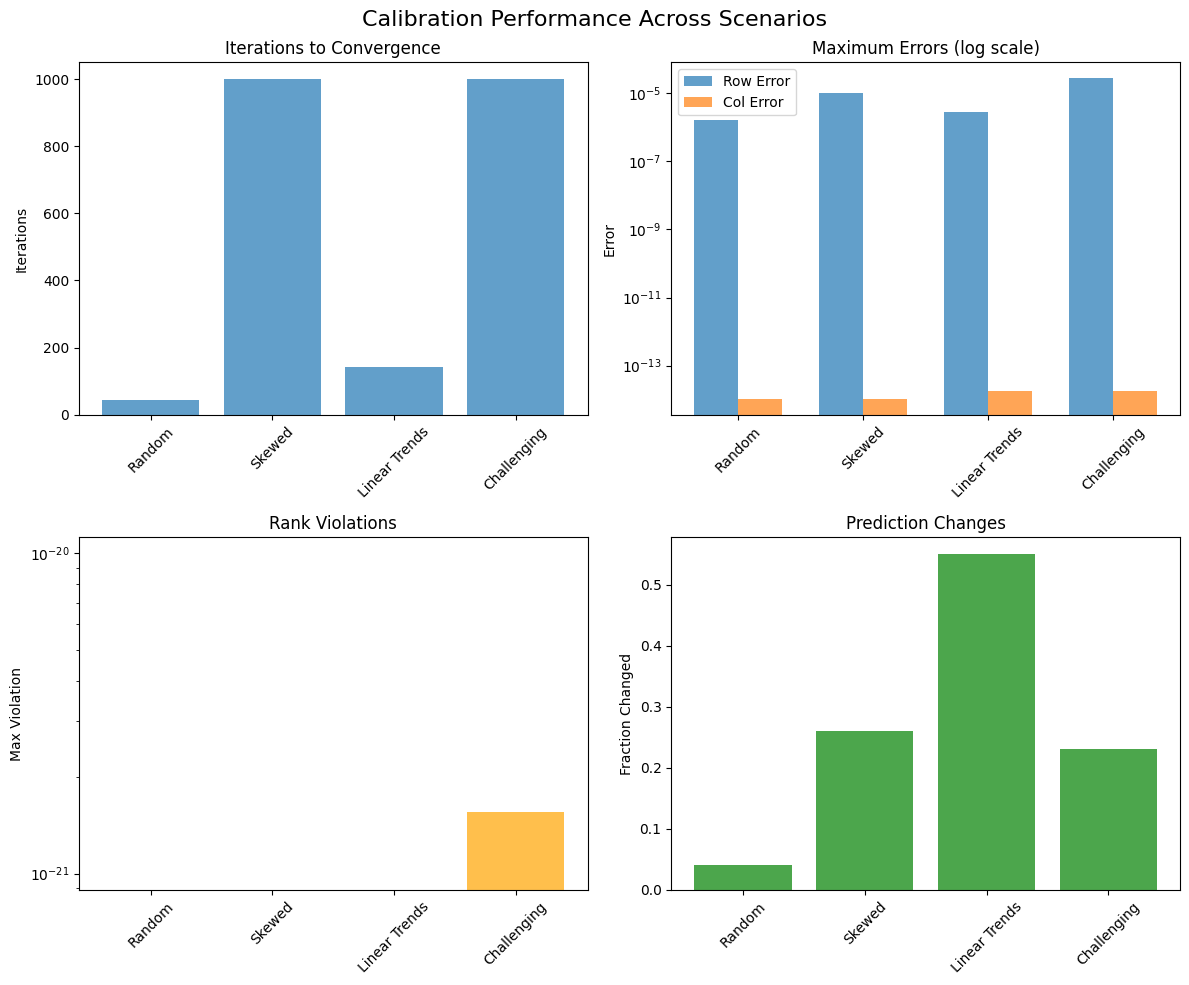

In [11]:
# Visualize scenario comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Calibration Performance Across Scenarios", fontsize=16)

scenarios_names = [r["scenario"] for r in results_summary]

# Plot 1: Convergence iterations
iterations = [r["iterations"] for r in results_summary]
axes[0, 0].bar(scenarios_names, iterations, alpha=0.7)
axes[0, 0].set_title("Iterations to Convergence")
axes[0, 0].set_ylabel("Iterations")
axes[0, 0].tick_params(axis="x", rotation=45)

# Plot 2: Maximum errors
row_errors = [r["row_error"] for r in results_summary]
col_errors = [r["col_error"] for r in results_summary]
x_pos = np.arange(len(scenarios_names))
width = 0.35
axes[0, 1].bar(x_pos - width / 2, row_errors, width, label="Row Error", alpha=0.7)
axes[0, 1].bar(x_pos + width / 2, col_errors, width, label="Col Error", alpha=0.7)
axes[0, 1].set_title("Maximum Errors (log scale)")
axes[0, 1].set_ylabel("Error")
axes[0, 1].set_yscale("log")
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(scenarios_names, rotation=45)
axes[0, 1].legend()

# Plot 3: Rank violations
rank_violations = [r["rank_violation"] for r in results_summary]
axes[1, 0].bar(scenarios_names, rank_violations, alpha=0.7, color="orange")
axes[1, 0].set_title("Rank Violations")
axes[1, 0].set_ylabel("Max Violation")
axes[1, 0].set_yscale("log")
axes[1, 0].tick_params(axis="x", rotation=45)

# Plot 4: Prediction changes
pred_changes = [r["prediction_changes"] for r in results_summary]
axes[1, 1].bar(scenarios_names, pred_changes, alpha=0.7, color="green")
axes[1, 1].set_title("Prediction Changes")
axes[1, 1].set_ylabel("Fraction Changed")
axes[1, 1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()